In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from graphviz import Digraph
import networkx as nx
from nxpd import draw

# Network modelling

This notebook describes some basic experiments with networks and graphs - specifically "trees" - for the purpose of building a simple, export-coefficient-based catchment model. 

## 1. Background: TEOTIL

At NIVA, we currently use the [TEOTIL model](https://brage.bibsys.no/xmlui/handle/11250/214825) to perform national scale loads estimation for the RID project. TEOTIL is coded in VB6 and, from a brief look at the report, it provides a flexible framework for developing export-coefficient-based models. 

The TEOTIL setup files currently used for the RID programme are *Run_totP_Norge_Regine.run* and *Run_totN_Norge_Regine.run*, which can be found here:

K:\Avdeling\Vass\Teotil2\Norge_Regine\RID_tilforsler\2015

Although the input files generated by Tore's code are quite complicated, the TEOTIL setup files looks comparatively simple, so I think TEOTIL is actually ignoring most of the input data provided. This suggests **we might be able to simplify the process of generating the TEOTIL input data**. 

An additional consideration is that TEOTIL is slow: each simulation currently takes 3 to 4 hours, so the total runtime for N an P is roughly 6 to 8 hours, and this will become even longer if we add other compnents in the future (e.g. heavy metals, which has been mentioned as a possibility). Export-coefficient-based models ought to be fast - even over large catchment networks - and the current runtimes for TEOTIL are more what I would expect from a dynamic, process-based model, rather than one underpinned by export coefficients. The aims of this notebook are therefore to:

 1. Try to better understand what TEOTIL is doing, and <br><br>
 
 2. Explore options for either altering the existing TEOTIL setup, or developing a simplified, faster version of the model specifically for the RID project  


### 1.1. TEOTIL input files

The `.run` files for TEOTIL give clues as to what the model is doing. The following is based on the [TEOTIL report](https://brage.bibsys.no/xmlui/handle/11250/214825), plus information in *Run_totP_Norge_Regine.run*.

The TEOTIL runs for the RID programme each year make use of several "static" files that are stored here:

K:\Avdeling\Vass\Teotil2\Norge_Regine

The files are as follows:

 * **`Regine.txt`**. This a key file, which represents the "regine" catchment network in Norway (~20000 catchments in total). The file includes basic catchment properties and - most importantly - for each catchment it gives the name of the next catchment downstream. This information is provided in a recursive/self-referencing table:

|  Regine  | RegineNed |
|:--------:|:---------:|
|  001.10  |    001.   |
|  001.1A1 |   001.10  |
| 001.1A20 |  001.1A1  |
| 001.1A2A |  001.1A20 |
| 001.1A40 |  001.1A3  |

 * **`Retensjon_Regine.txt`**. As far as I can tell, this file lists "retention factors" i.e. what proportions of the N and P flowing through a catchment are retained in that catchment (all the values are between 0 and 1, which supports this hypothesis).
 
 Note that the file only lists around 6500 catchments, so there must be some aggregation here compared to the full regine dataset. Based on the TEOTIL report, I believe these factors are estimated from numbers and sizes of lakes within each catchment. 
 
 If my understanding is correct, the amount of nutrient $X$ flowing out of catchment $i$, $O_i^X$, can be calculated something like this
 
 $$O_i^X = (1 - r_i^X) (L_i^X + I_i^X)$$
 
 where $r_i^X$ is the retention factor, $L_i^X$ is the "internal load" of nutrients added from within catchment $i$, and $I_i^X$ is the input of nutrients received from any upstream catchments. Arguably the most difficult part of building a model like TEOTIL is efficiently solving this equation, because the value of $I_i^X$ is the sum of the outputs from any catchments immediately upstream of $i$
 
 $$I_i^X = \sum_{j} O_j^X$$
 
 where the $j$ are the catchments that directly flow into catchment $i$. This is a recursive equation that must be solved in a particular order, because it is not possible to estimate the outflow from catchment $i$ without first calculating the outflow(s) from catchment(s) $j$. There are various strategies for dealing with this recursion, some of which are very slow. It is possible this is the primary cause of TEOTIL's long runtimes. <br><br>
 
 * **`Markslag_NIJOS_250.txt`**. Provides basic land cover proportions for the ~20000 regine catchments. (Note that the list of catchments doesn't quite match with that in `Regine.txt`). <br><br>
 
 * **`Innsjo_Areal_per_Regine.txt`**. Gives lakes areas per regine ID (because some lakes fall in more than 1 catchment). Note that there are only ~14000 regine IDs listed. <br><br>
 
 * **`koeffisienter_bakgrunn.txt`**. Background/natural inputs of N and P from different land cover types. Presumably can be linked with `Markslag_NIJOS_250.txt`. <br><br>
 
 * **`Regine_Fysone.txt`**. Lookup table linking regine IDs to Flyke-Sone IDs.
 
In addition to the files listed above, there are additional input files which change from year to year. Tore#s code writes 8 files in total, and these are decribed in detail in my [previous notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/prepare_teotil_inputs.ipynb). However, note that:

 * As John Rune pointed out in his e-mail (07/08/2017 at 16:11), two of these eight input files (*RID_Observert_Upper.txt* and *RID_Observert_Lower.txt*) are completely ignored by the model. <br><br>
 
 * In addition, most of the content of the other input files is also ignored. As far as I can tell, only the following data columns are used: <br><br>
 
     * `Qsnitt` and  `Qar` from `Q_Vassdrag.txt` (2 columns out of 14)
     * `Tot-P` and `Tot-N` from `AKVAKULTUR.txt` (2 columns out of 22)
     * `Tot-P` and `Tot-N` from `RENSEANLEGG.txt` (2 columns out of 22)
     * `Tot-P` and `Tot-N` from `SPREDT.txt` (2 columns out of 22)
     * `Tot-P`, `Tot-N` and `YEAR` from `INDUSTRI.txt` (3 columns out of 22)
     * `Paker`, `Pdyrket_nat`, `Naker` and `Ndyrket_nat` from `Koeffisienter_Jordbruk.txt` (4 columns out of 8)
     
Clearly, if we want to extend TEOTIL beyond N and P, some of the other information in the input files could be useful. Nevertheless, it looks as though there is substantial scope for simplifying this workflow. In addition, as pointed out by John Rune in his e-mail, it is now obvious why some of the bugs in the old code have no effect on the model output - the affected data are not actually used in the simulations.

### 1.2. TEOTIL calculations

TEOTIL appears to read all the above files into tabular data structures, and then joins them together to create a single, in-memory table with one row per regine. Various field calculations are then performed on this table to calculate the key values required for the network accumulation step (something like the recursive relationship described above). I haven't attempted to recreate all the table join and calculations yet, but they do not look complicated and should be fast - joining tables of ~20k records should take miliseconds, and I'm fairly confident these steps could be recreated without too much difficulty.

## 2. Networks and graphs

Based on the above, there are clearly some options for simplifying/streamlining the TEOTIL setup for the RID programme. Another option is to recode a new model, ideally using some more efficient data structures. This notebook won't go into too much detail, but I'd like to attempt a "proof-of-concept" as a starting point.

### 2.1. DAGs and Trees

[Graph theory](https://en.wikipedia.org/wiki/Graph_theory) is not my strong point, but if we assume that each catchment flows into **one and only one** downstream catchment (which is reasonable unless we're interested in e.g. artificial water transfers, such as for hydropower), we can model the catchment network as a [Directed Acyclic Graph (DAG)](https://en.wikipedia.org/wiki/Directed_acyclic_graph) or a [directed tree](https://en.wikipedia.org/wiki/Tree_(graph_theory%29#Polytree). Such structures allow for efficient computations across the network, as well as some useful visualisations of connectivity.

#### 2.1.1. Test example

As a simple example, consider the Kapos catchment network described on pages 48 and 51 of the [TEOTIL manual](https://brage.bibsys.no/xmlui/handle/11250/214825). Each catchment has a unique ID (`id`) and a single downstream ID (`to_id`). I have also added some simple, randomly generated catchment properties: column `li` gives the local/internal nutrient load for each catchment (i.e. the sum of all point and diffuse sources within the catchment itself), and `ti` lists the "transmission factors", which are the proportions of incoming nutrients that leave each catchment. This is pretty similar to a simplified TEOTIL setup, except I have replaced $(1 - r_i^X)$ from above with $t_i^X$ for simplicity, and I have also skipped over all the intermediate calculations required to estimate $L_i^X$ (because I'm fairly sure they will not be a performance bottleneck).

The column `oi_man` lists the pollutant loads leaving each catchment (allowing for upstream influences), which I've calculated manually in Excel for checking later.

In [2]:
# Read data
in_xls = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\Recoding_TEOTIL\Test_Data\test_data.xlsx')
df1 = pd.read_excel(in_xls, sheetname='Sheet1')
df1

,id,to_id,li,ti,oi_man
0,1,4,59,0.413699,24.408250
1,2,4,67,0.901986,60.433048
2,3,4,59,0.857783,50.609219
3,4,6,50,0.811013,150.402848
4,5,6,59,0.555489,32.773857
5,6,7,77,0.873453,227.252006
6,7,11,89,0.026004,8.223773
7,8,9,69,0.835807,57.670651
8,9,10,84,0.859581,121.777441
9,10,11,96,0.253062,55.111268


#### NetworkX

NetworkX is a python package for graph analysis. As a first attempt, I'll assign the `li` as node properties and the `ti` as edge weights.

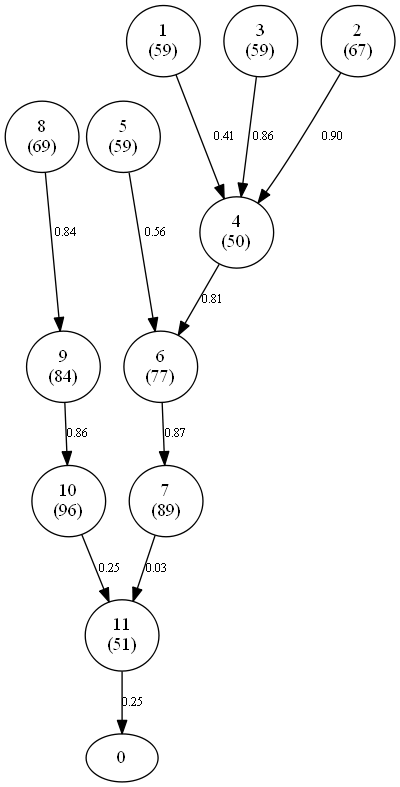

In [3]:
# Build graph from data table
g1 = nx.DiGraph()

# Add nodes with 'li' as property
for idx, row in df1.iterrows():
    nd = str(int(row['id']))
    li = str(int(row['li']))
    g1.add_node(nd, li=li, label='%s\n(%s)' % (nd, li))
     
# Add edges with 'ti' as edge weight
for idx, row in df1.iterrows():
    fr_nd = str(int(row['id']))
    to_nd = str(int(row['to_id']))
    wt = row['ti']
    g1.add_edge(fr_nd, to_nd, weight=wt, 
               label='%.2f' % wt, fontsize=10)

# Show inline
draw(g1, show='ipynb')

NetworkX automatically constructs a schematic visualisation of the network structure, which is great. We can also save the output as a `dot` file (a specialist data format for graphs) ready for further processing. `.dot` files are also useful for rendering graphs too big for an interactive notebook - see below.

In [4]:
# Save dot file
dot_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\Recoding_TEOTIL\DOT\test1.dot')
nx.write_dot(g1, dot_path)

#### Notes on `.dot` files for future reference

The dot file is just a plain text file that looks like this:

    strict digraph G {
    11 [li=51];
    10 [li=96];
    1 [li=59];
    0;
    3 [li=59];
    2 [li=67];
    5 [li=59];
    4 [li=50];
    7 [li=89];
    6 [li=77];
    9 [li=84];
    8 [li=69];
    11 -> 0  [weight="0.253991754131"];
    10 -> 11  [weight="0.253062334941"];
    1 -> 4  [weight="0.413699156736"];
    3 -> 4  [weight="0.857783368123"];
    2 -> 4  [weight="0.901985787205"];
    5 -> 6  [weight="0.55548909909"];
    4 -> 6  [weight="0.81101336527"];
    7 -> 11  [weight="0.0260038596338"];
    6 -> 7  [weight="0.873452548702"];
    9 -> 10  [weight="0.859581288222"];
    8 -> 9  [weight="0.83580653749"];
    }
    
To render this from the Windows `cmd` prompt, change to the directory containing the .dot file and run:

    dot test1.dot -Tpng -o test1.png -Gdpi=300

Other file formats may also be available (note that dpi doesn't necessarily work for SVG; not sure about EPS):

    dot test1.dot -Tps -o test1.eps
    dot test1.dot -Tsvg -o test1.svg
    
SVGs are quite useful because they stay crisp, and even large SVG files (like the entire Norwegian catchment network - see below) can be viewed reasonably well using IE or Chrome.

You can also modify the dot file quite easily, for example to adjust global properties. Inserting the following two lines before any of the node declarations (i.e. immediately after `strict digraph G {`) will turn off the arrowheads and render each node as a simple point, with no annotation (for clarity on large graphs).

    node[shape=point]
    edge[arrowhead=none]
    
#### Graphviz

Graphviz is another package for visualising graphs. It does not have the analysis power of NetworkX, but givers more control over styling and appearances. Using NetworkX and Graphviz in combinations seems like a powerful approach.

To control appearances in Graphviz, [styles](http://www.graphviz.org/content/attrs) can be defined in a dictionary and then applied to the graph using the function, as illustrated below. For this example we don't really need advanced styling, but it might be useful in the future.

In [5]:
# Dict of styles for grpah properties. Full list of options here:
# http://www.graphviz.org/content/attrs
styles = {
    'nodes': {
        'fontname': 'Arial',
        'fontsize': '12',
    },
    'edges': {
        'fontname': 'Arial',
        'fontsize': '8',
    }
}

def apply_styles(graph, styles):
    """ Applies styles from style dict to graph.
    """
    graph.graph_attr.update(
        ('graph' in styles and styles['graph']) or {}
    )
    graph.node_attr.update(
        ('nodes' in styles and styles['nodes']) or {}
    )
    graph.edge_attr.update(
        ('edges' in styles and styles['edges']) or {}
    )
    return graph

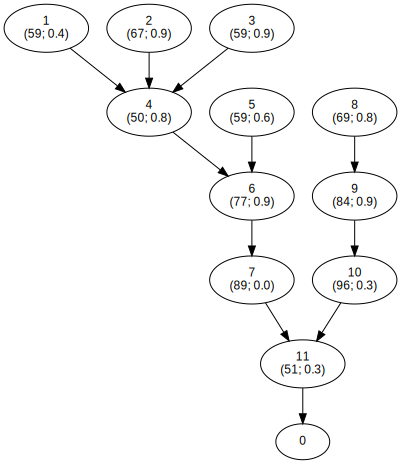

In [6]:
# Build graph using Graphviz
f = Digraph(comment='Catchment network')
f.attr(rankdir='UD', size='10')

# Add nodes
for idx, row in df1.iterrows():
    # To graph
    fr_nd = str(int(row['id']))
    f.node(fr_nd, label='%s\n(%d; %.1f)' % (fr_nd, row['li'], row['ti']))
     
# Add edges
for idx, row in df1.iterrows():
    fr_nd = str(int(row['id']))
    to_nd = str(int(row['to_id']))
    f.edge(fr_nd, to_nd)

f = apply_styles(f, styles)

f

#### Network calculations

To perform the kinds of calculations required for an export coefficient model, the easiest solution is to rebuild the network with all relevant properties assigned to the nodes (i.e. the catchments), as in the Graphviz example above. In this example we only have two properties per catchment ($L_i^X$ and $t_i^X$), but this can be generalised very easily to arbitrarily complex property sets. For example, we could add attributes representing the different kinds of point and diffuse inputs for multiple pollutants (N, P, metals). 

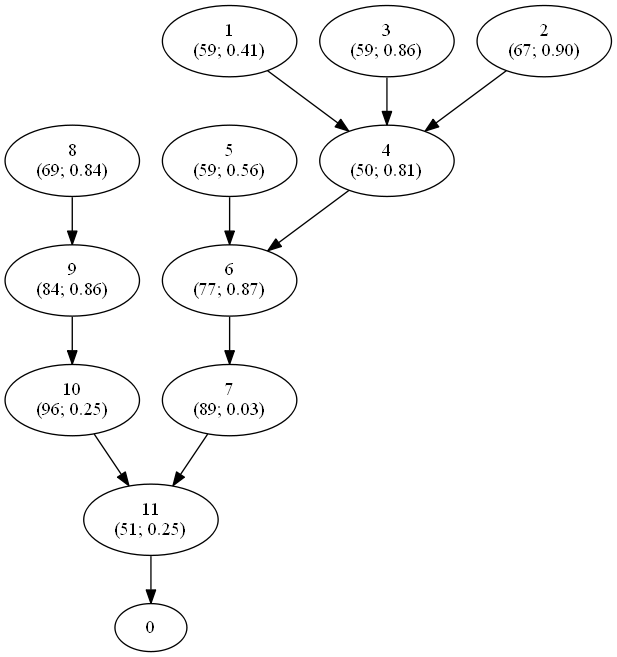

In [7]:
# Build graph
g1 = nx.DiGraph()

# Add nodes and attrs
for idx, row in df1.iterrows():
    nd = str(int(row['id']))
    li = int(row['li'])
    wt = row['ti']
    g1.add_node(nd, li=li, wt=wt, 
                label='%s\n(%s; %.2f)' % (nd, li, wt))
     
# Add edges
for idx, row in df1.iterrows():
    fr_nd = str(int(row['id']))
    to_nd = str(int(row['to_id']))
    g1.add_edge(fr_nd, to_nd)

# Show inline
draw(g1, show='ipynb')

We can now define a function to process the downstream accumulation of nutrients. For each node, we perform the following calculation (described in section 1.1, above):

$$O_i^X = (1 - r_i^X) (L_i^X + I_i^X)$$

The order in which the nodes must be processed for this to work are determined by the topology of the network, as determined by the `topological_sort()` function. Although conceptually quite comlicated, the core of the model becomes just a few lines of code using NetworkX, which is great.

In [8]:
def accumulate_loads(g):
    """ Core function for TEOTIL-like network accumulation over a
        hydrological network.
    
    Args
        g Pre-built NetworkX graph. Must be a directed tree/forest
          and each nodes must have properties 'li' (internal load)
          and 'wt' (transmission factor)
          
    Returns
        Graph. g is modifed by adding the property 'Oi' to each node.
        This is the total amount of nutrient flowing out of the node.  
    """
    import networkx as nx
    
    # Check directed tree
    assert nx.is_tree(g), 'g is not a valid tree.'
    assert nx.is_directed_acyclic_graph(g), 'g is not a valid DAG.'   
    
    # Process nodes in topo order from headwaters down
    for nd in nx.topological_sort(g)[:-1]:
        # Get catchments directly upstream
        preds = g.predecessors(nd)
        
        if len(preds) > 0:
            # Accumulate total input from upstream
            ii = 0
            for pred in preds:
                ii += g.node[pred]['oi']

            # Calculate output. Oi = ti * (Li + Ii)
            g.node[nd]['oi'] = g.node[nd]['wt'] * (g.node[nd]['li'] + ii)

        else:
            # No upstream inputs. Oi = ti * Li
            g.node[nd]['oi'] = g.node[nd]['li'] * g.node[nd]['wt']  
    
    return g

In [9]:
# Run model
g1 = accumulate_loads(g1)

# Compare results to Excel
res = []
for nd in df1['id']:    
    res.append(g1.node[str(nd)]['oi'])
df1['oi_nx'] = res

print 'Results identical: %s' % np.isclose(df1['oi_man'], 
                                           df1['oi_nx']).all()

df1

Results identical: True


,id,to_id,li,ti,oi_man,oi_nx
0,1,4,59,0.413699,24.408250,24.408250
1,2,4,67,0.901986,60.433048,60.433048
2,3,4,59,0.857783,50.609219,50.609219
3,4,6,50,0.811013,150.402848,150.402848
4,5,6,59,0.555489,32.773857,32.773857
5,6,7,77,0.873453,227.252006,227.252006
6,7,11,89,0.026004,8.223773,8.223773
7,8,9,69,0.835807,57.670651,57.670651
8,9,10,84,0.859581,121.777441,121.777441
9,10,11,96,0.253062,55.111268,55.111268


## 3. Norway catchment network

The same input files used by TEOTIL can be used here too. The Norwegian catchment network is described in *Regine.txt* (see section 1.1, above). I have made two copies of this file: the first is just a copy of the original, as used by TEOTIL (i.e. all ~20000 catchments); for the second, I've deleted everything except the catchments belonging to vassdrag number `001`. The second file will be used as an intermediate scaling test, in-between my simple example above and the full regine dataset.

### 3.1. Vassdrag 001.

In [10]:
# Start with the simplified file
in_txt = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\Recoding_TEOTIL\Test_Data\Regine_Vassdr1_Only.txt')
df2 = pd.read_csv(in_txt, sep=';')
df2 = df2[['Regine', ' RegineNed']]
df2.columns = ['id', 'to_id']
df2.head()

,id,to_id
0,001.10,001.
1,001.1A1,001.10
2,001.1A20,001.1A1
3,001.1A2A,001.1A20
4,001.1A2B,001.1A2A


In [11]:
# Build graph (no weights or properties for now)
g2 = nx.DiGraph()

# Add nodes
for idx, row in df2.iterrows():
    nd = row['id']
    g2.add_node(nd)
    
# Add edges
for idx, row in df2.iterrows():
    fr_nd = row['id']
    to_nd = row['to_id']
    g2.add_edge(fr_nd, to_nd)

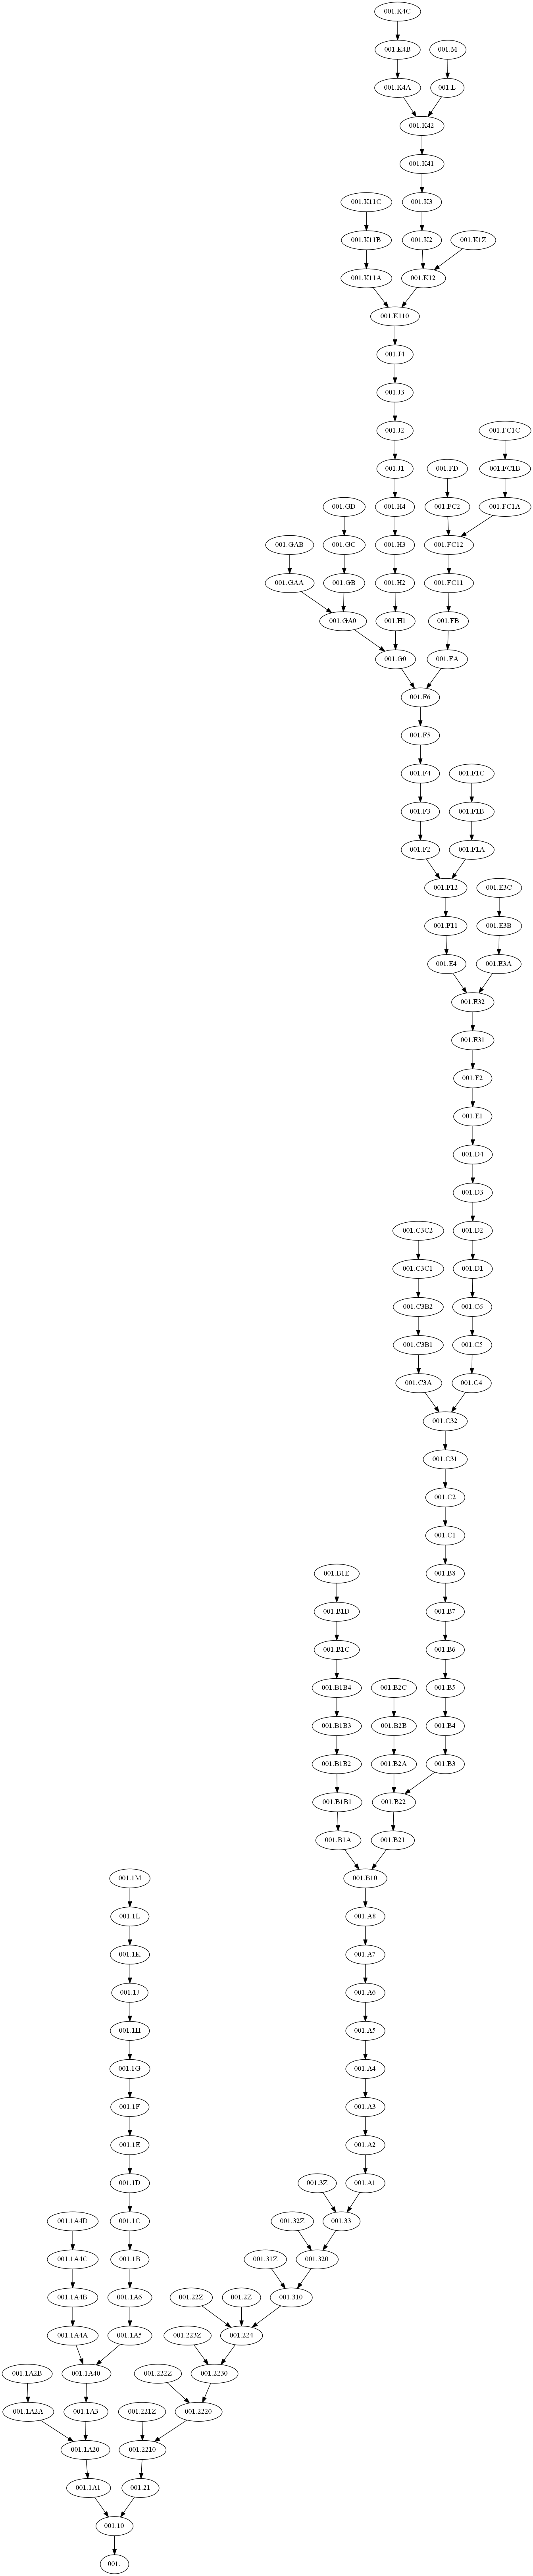

In [12]:
# Check directed tree
assert nx.is_tree(g2), 'Graph is not a valid tree.'
assert nx.is_directed_acyclic_graph(g2), 'Graph is not a valid DAG.'

draw(g2, show='ipynb')

This looks promising - the dataset is a true directed tree and generating and plotting the network too only a fraction of a second. Given this, I think it's OK to try the full dataset.

### 3.2. Full regine dataset

In [13]:
# Read the full dataset
in_txt = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\Recoding_TEOTIL\Test_Data\Regine.txt')
df3 = pd.read_csv(in_txt, sep=';')
df3 = df3[['Regine', ' RegineNed']]
df3.columns = ['id', 'to_id']

print 'Total number of regine IDs:', len(df3)

df3.head()

Total number of regine IDs: 20474


,id,to_id
0,001.10,001.
1,001.1A1,001.10
2,001.1A20,001.1A1
3,001.1A2A,001.1A20
4,001.1A2B,001.1A2A


As a first step, I'm going to build the graph without any node properties and then export the whole thing to `.dot` format for visualisation. This is quite an underatking - it's a schematic network diagram of the entire Norwegian drainage system!

In [14]:
# Build graph (no weights or properties for now)
g3 = nx.DiGraph()

# Add nodes
for idx, row in df3.iterrows():
    nd = row['id']
    g3.add_node(nd)
    
# Add edges
for idx, row in df3.iterrows():
    fr_nd = row['id']
    to_nd = row['to_id']
    g3.add_edge(fr_nd, to_nd)

In [15]:
# Save dot file
dot_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\Recoding_TEOTIL\DOT\regine.dot')
nx.write_dot(g3, dot_path)

This network diagram is much too big to be embedded in a Jupyter notebook. Instead, I've converted it to a large (12 Mb) SVG file using the Graphviz command line: 

    dot regine.dot -Tsvg -o regine.svg
    
The file is on the network here:

K:\Prosjekter\JES\RID\regine.svg

and it can be viewed using e.g. Internet Explorer (but be prepared to zoom in and scroll around a lot!).

### 3.3. Calculations on the full dataset

To test how well my code scales, I'm going to generate random values for the $L_i^X$ and $t_i^X$ for the full dataset and then try running the same workflow as the simple example above. It is impossible to check the answer produced by this calculation, so some careful debugging will be required if we decide to take these ideas further, but for now I just want to confirm that the network calculations are possible and reasonably fast at this scale. With this in mind, I'll use the `%%time` function to see how long it takes to build the network and accumulate pollutants downstream.

In [16]:
# Add random numbers for li and ti
df3['li'] = np.random.randint(low=1, high=100, size=len(df3))
df3['ti'] = np.random.uniform(low=0, high=1, size=len(df3))

df3.head()

,id,to_id,li,ti
0,001.10,001.,90,0.286273
1,001.1A1,001.10,32,0.539547
2,001.1A20,001.1A1,89,0.059946
3,001.1A2A,001.1A20,79,0.865531
4,001.1A2B,001.1A2A,9,0.113052


In [17]:
%%time

# Build graph again, this time assigning node properties
g3 = nx.DiGraph()

# Add nodes and attrs
for idx, row in df3.iterrows():
    nd = row['id']
    li = int(row['li'])
    wt = row['ti']
    g3.add_node(nd, li=li, wt=wt, 
                label='%s\n(%s; %.2f)' % (nd, li, wt))
     
# Add edges
for idx, row in df3.iterrows():
    fr_nd = row['id']
    to_nd = row['to_id']
    g3.add_edge(fr_nd, to_nd)

# Run model
g3 = accumulate_loads(g3)

# Print outflow load from lowest node
# Get lowest catch ID (that isn't '0')
ds_nd = nx.topological_sort(g3)[-2]

print 'Number of nodes in network:', g3.number_of_nodes()
print 'Load from downstream node (%s): %.2f.' % (ds_nd, g3.node[ds_nd]['oi'])
print ''

Number of nodes in network: 20475
Load from downstream node (1_315): 121.48.

Wall time: 3.41 s


This looks pretty promising. I have not replicated all the calculations performed by TEOTIL, but most of what I've omitted are table joins and array calculations, which are very fast. The complciated part is the network accumulation, which takes just over 3 seconds for the full Norwegian drainage system. Overall, **I estimate we could build a basic TEOTIL-like model in Python without too much difficulty and with runtimes of ~30 seconds, instead of 6 to 8 hours or more**.